In [64]:
from mflex.load.read_file import read_issi_analytical
import numpy as np
from mflex.plot.plot_magnetogram import (
    plot_fieldlines_issi_analytical,
)
from mflex.model.field.bfield_model import magnetic_field_test
import scipy
import matplotlib.pyplot as plt
from mflex.model.plasma_parameters_new import (
    deltapres,
    deltaden,
    btemp_linear,
    bpressure_linear,
    bdensity_linear,
)
from mflex.evaluate.metrics import (
    vec_corr_metric,
    cau_Schw_metric,
    norm_vec_err_metric,
    mean_vec_err_metric,
    mag_ener_metric,
    field_div_metric,
    pearson_corr_coeff,
)
from mflex.model.field.utility.height_profile import f_low, f
from mflex.model.field.save import save_field
import matplotlib

In [65]:
path3d = "/Users/lilli/Desktop/mflex/data/Analytic_3D_data.sav"
data3d = scipy.io.readsav(path3d, python_dict=True, verbose=True)

print(data3d["info_unit"])
print(data3d["info_pixel"])
print(data3d["info_array"])

data_bx_ref = data3d["b3dx"]
data_by_ref = data3d["b3dy"]
data_bz_ref = data3d["b3dz"]

pres_3d = data3d["p3d"] * 10**-1
den_3d = data3d["d3d"] * 10**3

print("Pressure minimum", pres_3d.min())
print("Density minimum", den_3d.min())

print("Pressure maximum", pres_3d.max())
print("Density maximum", den_3d.max())

--------------------------------------------------
Date: Tue Sep  6 15:11:11 2022
User: xszhu
Host: HR30
--------------------------------------------------
Format: 9
Architecture: x86_64
Operating System: linux
IDL Version: 7.1.1
--------------------------------------------------
Successfully read 12 records of which:
 - 1 are of type VERSION
 - 1 are of type NOTICE
 - 8 are of type VARIABLE
 - 1 are of type TIMESTAMP
--------------------------------------------------
Available variables:
 - b3dx [<class 'numpy.ndarray'>]
 - b3dy [<class 'numpy.ndarray'>]
 - b3dz [<class 'numpy.ndarray'>]
 - p3d [<class 'numpy.ndarray'>]
 - d3d [<class 'numpy.ndarray'>]
 - info_unit [<class 'bytes'>]
 - info_pixel [<class 'bytes'>]
 - info_array [<class 'bytes'>]
--------------------------------------------------
b'b3d, p3d, d3d: magnetic vector (Gauss), plasma pressure (dyn/cm^2), plasma density (g/cm^3)'
b'Pixel spacing: 40km*40km*40km'
b'Array example: d3d(nx,ny,nz)'
Pressure minimum 0.43188784
Dens

In [66]:
# data = read_issi_analytical("data/Analytic_boundary_data.sav")
cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
    "", ["dimgray", "whitesmoke"]
)

L = 1.6
data = read_issi_analytical(
    "/Users/lilli/Desktop/mflex/data/Analytic_boundary_data.sav", L
)
# BFieldvec_Seehafer = np.load('field_data_potential.npy')

data_bx = data.data_x
data_by = data.data_y
data_bz = data.data_z
nresol_x = data.nresol_x
nresol_y = data.nresol_y
nresol_z = data.nresol_z
pixelsize_x = data.pixelsize_x
pixelsize_y = data.pixelsize_y
pixelsize_z = data.pixelsize_z
nf_max = data.nf_max
xmin = data.xmin
xmax = data.xmax
ymin = data.ymin
ymax = data.ymax
zmin = data.zmin
zmax = data.zmax
z0 = data.z0

deltaz = z0 / 10.0  # z0 at 2Mm so widht of transition region = 200km

print("z0, deltaz", z0, deltaz)

--------------------------------------------------
Date: Tue Sep  6 15:16:46 2022
User: xszhu
Host: HR30
--------------------------------------------------
Format: 9
Architecture: x86_64
Operating System: linux
IDL Version: 7.1.1
--------------------------------------------------
Successfully read 33 records of which:
 - 1 are of type VERSION
 - 1 are of type NOTICE
 - 29 are of type VARIABLE
 - 1 are of type TIMESTAMP
--------------------------------------------------
Available variables:
 - b2dx1 [<class 'numpy.ndarray'>]
 - b2dy1 [<class 'numpy.ndarray'>]
 - b2dz1 [<class 'numpy.ndarray'>]
 - d2d1 [<class 'numpy.ndarray'>]
 - b2dx2 [<class 'numpy.ndarray'>]
 - b2dy2 [<class 'numpy.ndarray'>]
 - b2dz2 [<class 'numpy.ndarray'>]
 - d2d2 [<class 'numpy.ndarray'>]
 - b2dx3 [<class 'numpy.ndarray'>]
 - b2dy3 [<class 'numpy.ndarray'>]
 - b2dz3 [<class 'numpy.ndarray'>]
 - d2d3 [<class 'numpy.ndarray'>]
 - b2dx4 [<class 'numpy.ndarray'>]
 - b2dy4 [<class 'numpy.ndarray'>]
 - b2dz4 [<class '

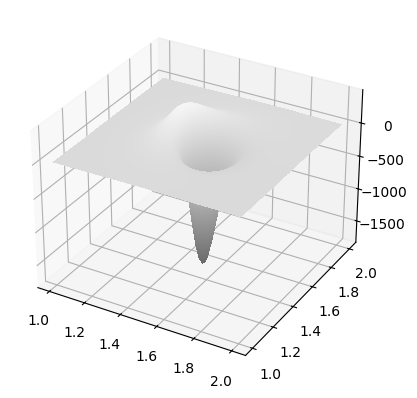

In [67]:
x_arr = np.arange(2 * nresol_x) * (xmax - xmin) / (2 * nresol_x - 1) + xmin
y_arr = np.arange(2 * nresol_y) * (ymax - ymin) / (2 * nresol_y - 1) + ymin
z_arr = np.arange(nresol_z) * (zmax - zmin) / (nresol_z - 1) + zmin
x_grid, y_grid = np.meshgrid(x_arr, y_arr)
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.contourf(
    x_grid[nresol_y : 2 * nresol_y, nresol_x : 2 * nresol_x],
    y_grid[nresol_y : 2 * nresol_y, nresol_x : 2 * nresol_x],
    data_bz,
    1000,
    # offset=0.0,
    cmap=cmap,
)
plt.show()

In [68]:
t_photo = 6000.0
t0 = 10000.0

temps = [t_photo, 5500.0, t0]
heights = [0.0, z0 / 4, z0]

g_solar = 272.2  # kg/m^3
kB = 1.380649 * 10**-23  # Boltzmann constant in Joule/ Kelvin = kg m^2/(Ks^2)
mbar = 1.67262 * 10**-27  # mean molecular weight (proton mass)
rho_photo = 3.0 * 10**-4
b_photo = 1792.2522  # Gauss, NOT SI
h0 = kB * t0 / (mbar * g_solar)
h_photo = kB * t_photo / (mbar * g_solar)
p_photo = t_photo * kB * rho_photo / mbar
mu0 = 1.25663706 * 10**-6
pB_photo = (b_photo * 10**-4) ** 2 / (2 * mu0)
beta_photo = p_photo / pB_photo
l = 10**-6 * L**-1

h0_star = h0 * l
h_photo_star = h_photo * l

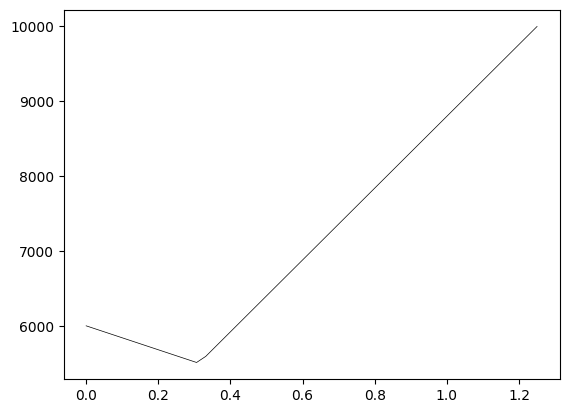

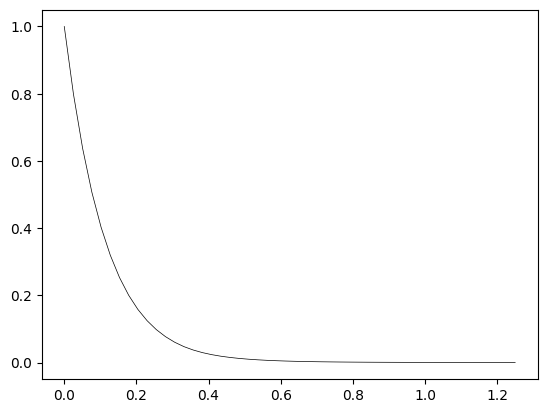

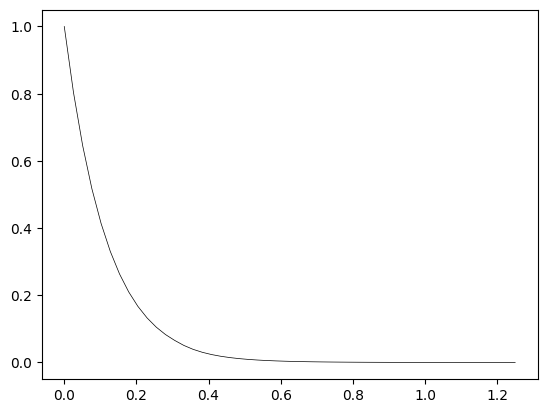

In [69]:
btemp_arr = np.zeros_like(z_arr)
bpres_arr = np.zeros_like(z_arr)
bden_arr = np.zeros_like(z_arr)

for iz, z in enumerate(z_arr):
    btemp_arr[iz] = btemp_linear(z, temps, heights)
    bpres_arr[iz] = bpressure_linear(z, temps, heights, t0, h0_star)
    bden_arr[iz] = bdensity_linear(z, temps, heights, t0, h0_star, t_photo)


plt.plot(
    z_arr,
    btemp_arr,
    linewidth=0.5,
    color="black",
    linestyle="solid",
)
plt.show()

plt.plot(
    z_arr,
    bpres_arr,
    linewidth=0.5,
    color="black",
    linestyle="solid",
)
plt.show()

plt.plot(
    z_arr,
    bden_arr,
    linewidth=0.5,
    color="black",
    linestyle="solid",
)
plt.show()

In [70]:
a = 0.5 * np.exp(-0.02 * z0)
b = -(0.5 / a - 1.0) / np.tanh(-z0 / deltaz)
alpha = -0.48


bfield, dbfield = magnetic_field_test(
    data_bz,
    z0,
    deltaz,
    a,
    b,
    alpha,
    xmin,
    xmax,
    ymin,
    ymax,
    zmin,
    zmax,
    nresol_x,
    nresol_y,
    nresol_z,
    pixelsize_x,
    pixelsize_y,
    nf_max,
)

print("Maximum b", bfield.max())

Maximum b 1774.962136452199


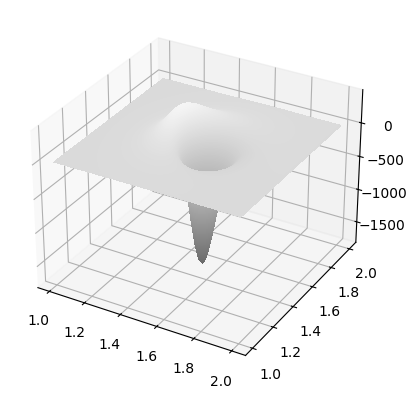

In [71]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.contourf(
    x_grid[nresol_y : 2 * nresol_y, nresol_x : 2 * nresol_x],
    y_grid[nresol_y : 2 * nresol_y, nresol_x : 2 * nresol_x],
    bfield[nresol_y : 2 * nresol_y, nresol_x : 2 * nresol_x, 0, 2],
    1000,
    cmap=cmap,
)
plt.show()

In [72]:
bfield_star = bfield[nresol_y : 2 * nresol_y, nresol_x : 2 * nresol_x, :, :] / b_photo
dbfield_star = dbfield[nresol_y : 2 * nresol_y, nresol_x : 2 * nresol_x, :, :] / b_photo

bdotgradbz_star = (
    bfield_star[:, :, :, 1] * dbfield_star[:, :, :, 1]
    + bfield_star[:, :, :, 0] * dbfield_star[:, :, :, 0]
    + bfield_star[:, :, :, 2] * dbfield_star[:, :, :, 2]
)

In [73]:
dp_arr = deltapres(z_arr, z0, deltaz, a, b, bfield_star[:, :, :, 2])
dd_arr = deltaden(z_arr, z0, deltaz, a, b, bfield_star[:, :, :, 2], bdotgradbz_star, l)

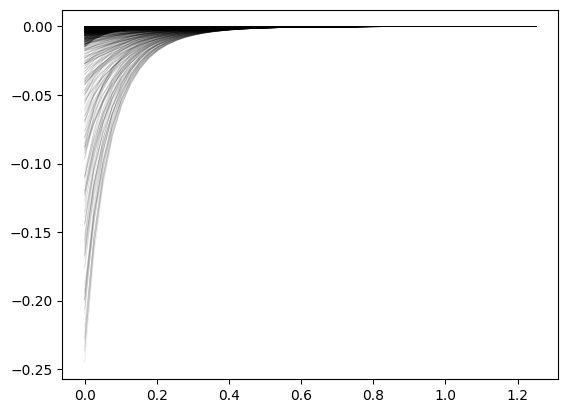

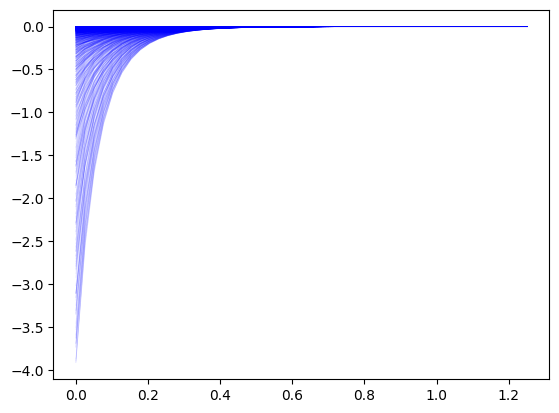

In [74]:
for ix in range(nresol_x):
    for iy in range(nresol_y):
        plt.plot(
            z_arr,
            dp_arr[iy, ix, :],
            linewidth=0.5,
            color="black",
            linestyle="solid",
            alpha=0.1,
        )
plt.show()

for ix in range(nresol_x):
    for iy in range(nresol_y):
        plt.plot(
            z_arr,
            dd_arr[iy, ix, :],
            linewidth=0.5,
            color="blue",
            linestyle="solid",
            alpha=0.1,
        )
plt.show()

In [75]:
cube1, cube2, Backpres_star = np.meshgrid(
    np.ones(nresol_x), np.ones(nresol_y), beta_photo / 2.0 * bpres_arr
)  # Dimensionless
cube1, cube2, Backden_star = np.meshgrid(
    np.ones(nresol_x), np.ones(nresol_y), beta_photo / (2 * h_photo_star) * bden_arr
)

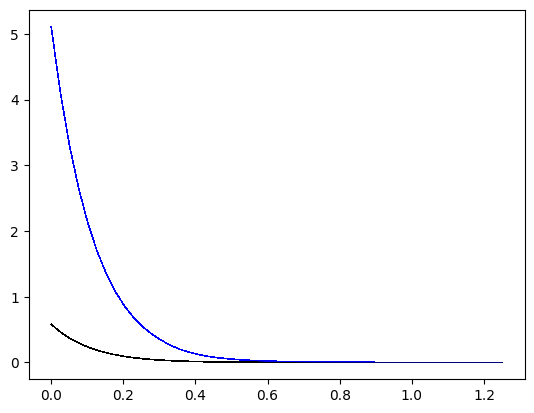

In [76]:
for ix in range(nresol_x):
    for iy in range(nresol_y):
        plt.plot(
            z_arr,
            Backpres_star[iy, ix, :],
            linewidth=0.5,
            color="black",
            linestyle="solid",
            alpha=0.1,
        )
        plt.plot(
            z_arr,
            Backden_star[iy, ix, :],
            linewidth=0.5,
            color="blue",
            linestyle="solid",
            alpha=0.1,
        )
plt.show()

In [77]:
full_pressure_star = Backpres_star + dp_arr
full_density_star = Backden_star + dd_arr

In [78]:
for ix in range(nresol_x):
    for iy in range(nresol_y):
        plt.plot(
            z_arr,
            full_pressure_star[iy, ix, :],
            linewidth=0.5,
            color="black",
            linestyle="solid",
            alpha=0.1,
        )
        plt.plot(
            z_arr,
            pres_3d[:, iy, ix],
            linewidth=0.5,
            color="blue",
            linestyle="solid",
            alpha=0.1,
        )
plt.show()

for ix in range(nresol_x):
    for iy in range(nresol_y):
        plt.plot(
            z_arr,
            full_density_star[iy, ix, :],
            linewidth=0.5,
            color="black",
            linestyle="solid",
            alpha=0.1,
        )
        plt.plot(
            z_arr,
            den_3d[:, iy, ix],
            linewidth=0.5,
            color="blue",
            linestyle="solid",
            alpha=0.1,
        )
plt.show()

print("pressure min", full_pressure_star.min())
print("density min", full_density_star.min())

print("pressure max", full_pressure_star.max())
print("density max", full_density_star.max())

In [ ]:
print("pressure min Ref", pres_3d.min())
print("density min Ref", den_3d.min())

print("pressure max Ref", pres_3d.max())
print("density max Ref", den_3d.max())

pressure min Ref 4.318878
density min Ref 4.975967e-12
pressure max Ref 133868.25
density max Ref 2.698494e-07


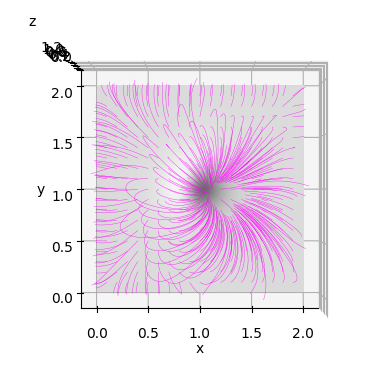

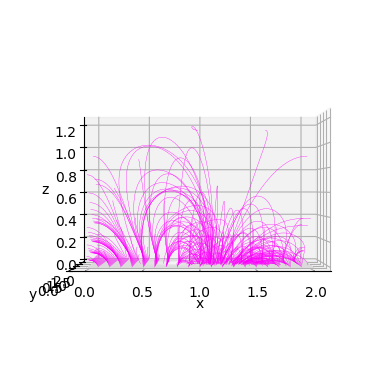

In [ ]:
h1 = 0.01  # Initial step length for fieldline3D
eps = 1.0e-8
# Tolerance to which we require point on field line known for fieldline3D
hmin = 0.0  # Minimum step length for fieldline3D
hmax = 1.0  # Maximum step length for fieldline3D

plot = plot_fieldlines_issi_analytical(
    bfield,
    h1,
    hmin,
    hmax,
    eps,
    nresol_x,
    nresol_y,
    nresol_z,
    -xmax,
    xmax,
    -ymax,
    ymax,
    zmin,
    zmax,
    a,
    b,
    alpha,
    stepsize=0.1,
    view="top",
    cmap=cmap,
)

plot = plot_fieldlines_issi_analytical(
    bfield,
    h1,
    hmin,
    hmax,
    eps,
    nresol_x,
    nresol_y,
    nresol_z,
    -xmax,
    xmax,
    -ymax,
    ymax,
    zmin,
    zmax,
    a,
    b,
    alpha,
    stepsize=0.1,
    view="side",
    cmap=cmap,
)